In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import time
import re
from scipy import stats
from urllib.parse import urljoin
import warnings
warnings.filterwarnings('ignore')
import japanize_matplotlib


In [3]:
class DataScraper:
    """Webサイトからデータを取得・解析するクラス"""
    
    def __init__(self):
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }
        # 今回のターゲットに合わせてドメイン設定（robots.txt確認用）
        self.base_url = 'https://uub.jp'
        
    def check_robots_txt(self):
        """robots.txtを確認"""
        robots_url = urljoin(self.base_url, '/robots.txt')
        print(f"robots.txt確認中: {robots_url}")
        time.sleep(1)
        
        try:
            response = requests.get(robots_url, headers=self.headers, timeout=10)
            if response.status_code == 200:
                print(f"Status: {response.status_code} - 確認完了")
                return True
            elif response.status_code == 404:
                print("robots.txt not found (404) - スクレイピング可能と判断")
                return True
            else:
                print(f"Status: {response.status_code} - 続行します")
                return True
        except Exception as e:
            print(f"Error checking robots.txt: {e}")
            return False
            
    def fetch_page(self, url, wait_time=3):
        """ページを取得(サーバー負荷に配慮)"""
        try:
            print(f"アクセス中: {url}")
            time.sleep(wait_time)
            response = requests.get(url, headers=self.headers, timeout=15)
            response.raise_for_status()
            response.encoding = response.apparent_encoding
            return BeautifulSoup(response.content, 'html.parser')
        except Exception as e:
            print(f"Error fetching {url}: {e}")
            raise

    def scrape_data(self, url, prefecture_list, year_keywords=None):
        """指定URLから都道府県別データを抽出"""
        soup = self.fetch_page(url)
        data = {}
        
        # タイトル取得（グラフのラベル用）
        title = soup.title.text.strip() if soup.title else "データ"
        clean_title = re.sub(r' \|.*|都道府県ランキング', '', title).strip()
        print(f"  取得対象: {clean_title}")

        # テーブル特定
        tables = soup.find_all('table')
        target_table = None
        for table in tables:
            if len(table.find_all('tr')) >= 47:
                target_table = table
                break
        if not target_table:
            target_table = tables[0]

        # ヘッダー解析による対象列の特定（2013年/平成25年を探す）
        target_col_offset = 0  # 都道府県列から何番目右の列か（0なら直後の列）
        
        if year_keywords:
            header_rows = target_table.find_all('tr')[:3]
            for row in header_rows:
                cells = row.find_all(['th', 'td'])
                for i, cell in enumerate(cells):
                    text = cell.get_text(strip=True)
                    for kw in year_keywords:
                        if kw in text:
                            print(f"  キーワード '{kw}' をヘッダーで検出しました。")
                            # ここで列位置を厳密に特定するのは難しいため、
                            # 検出されたという事実のみを確認し、データ取得は柔軟に行う
                            break

        # データ抽出
        rows = target_table.find_all('tr')
        valid_count = 0
        
        for row in rows:
            cells = row.find_all(['td', 'th'])
            if len(cells) < 2:
                continue
            
            cell_texts = [c.get_text(strip=True) for c in cells]
            
            # 都道府県名の特定
            found_pref = None
            pref_idx = -1
            
            for i, text in enumerate(cell_texts):
                clean_text = text.replace(' ', '').replace('　', '')
                for pref in prefecture_list:
                    # 前方一致かつ文字数チェック（誤検知防止）
                    if clean_text == pref or (clean_text.startswith(pref) and len(clean_text) <= len(pref)+1):
                        found_pref = pref
                        pref_idx = i
                        break
                if found_pref:
                    break
            
            if not found_pref or found_pref in data:
                continue

            # 数値の取得（都道府県名の右側を探索）
            candidates = []
            for i in range(pref_idx + 1, len(cell_texts)):
                text = cell_texts[i]
                # カンマ削除、数値変換
                num_str = re.sub(r'[^0-9.\-]', '', text)
                if num_str:
                    try:
                        val = float(num_str)
                        candidates.append(val)
                    except ValueError:
                        continue
            
            # データが見つかった場合（通常は一番左の数値を採用）
            if candidates:
                # 特定の列指定ロジックがあればここで分岐可能だが、
                # 基本的にuub.jpは左端が主要データのため0番目を採用
                data[found_pref] = candidates[target_col_offset]
                valid_count += 1

        print(f"  データ取得完了: {valid_count}件")
        return data, clean_title

In [4]:
class SmartScraper:
    def __init__(self):
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)',
            'Accept-Language': 'ja'
        }
    
    def fetch_page(self, url):
        time.sleep(3)
        try:
            print(f"アクセス中: {url}")
            response = requests.get(url, headers=self.headers, timeout=20)
            response.raise_for_status()
            response.encoding = response.apparent_encoding
            return BeautifulSoup(response.content, 'html.parser')
        except Exception as e:
            print(f"接続エラー: {e}")
            raise

    def scrape_data(self, url, prefecture_list, year_keywords=None):
        soup = self.fetch_page(url)
        data = {}
        title = soup.title.text.strip() if soup.title else "データ"
        clean_title = re.sub(r' \|.*', '', title).replace('都道府県ランキング', '').strip()
        print(f"  取得対象: {clean_title}")

        tables = soup.find_all('table')
        target_table = None
        for table in tables:
            if len(table.find_all('tr')) >= 47:
                target_table = table
                break
        
        if not target_table:
            target_table = tables[0]

        # ヘッダー解析 (年次キーワードの確認)
        if year_keywords:
            headers = target_table.find_all('tr')[0].find_all(['th', 'td'])
            for row_idx in range(min(3, len(target_table.find_all('tr')))):
                header_cells = target_table.find_all('tr')[row_idx].find_all(['th', 'td'])
                for cell in header_cells:
                    cell_text = cell.get_text(strip=True)
                    for kw in year_keywords:
                        if kw in cell_text:
                            print(f"  キーワード確認: {kw}")
                            break

        # データ行の解析
        rows = target_table.find_all('tr')
        valid_count = 0
        
        for row in rows:
            cells = row.find_all(['td', 'th'])
            if len(cells) < 2:
                continue
            
            cell_texts = [c.get_text(strip=True) for c in cells]
            
            # 都道府県名の特定
            found_pref = None
            pref_idx = -1
            
            for i, text in enumerate(cell_texts):
                clean_text = text.replace(' ', '').replace('　', '')
                for pref in prefecture_list:
                    if clean_text == pref or (clean_text.startswith(pref) and len(clean_text) <= len(pref)+1):
                        found_pref = pref
                        pref_idx = i
                        break
                if found_pref:
                    break
            
            if not found_pref or found_pref in data:
                continue

            # 数値の取得
            candidates = []
            for i in range(pref_idx + 1, len(cell_texts)):
                text = cell_texts[i]
                num_str = re.sub(r'[^0-9.\-]', '', text)
                if num_str:
                    try:
                        val = float(num_str)
                        candidates.append(val)
                    except ValueError:
                        continue
            
            if candidates:
                value = candidates[0]
                data[found_pref] = value
                valid_count += 1

        print(f"  データ取得完了: {valid_count}件")
        return data, clean_title

In [5]:
# 1. スクレイパー初期化
scraper = DataScraper()
scraper.check_robots_txt()

PREFECTURES = [
    '北海道', '青森県', '岩手県', '宮城県', '秋田県', '山形県', '福島県',
    '茨城県', '栃木県', '群馬県', '埼玉県', '千葉県', '東京都', '神奈川県',
    '新潟県', '富山県', '石川県', '福井県', '山梨県', '長野県',
    '岐阜県', '静岡県', '愛知県', '三重県',
    '滋賀県', '京都府', '大阪府', '兵庫県', '奈良県', '和歌山県',
    '鳥取県', '島根県', '岡山県', '広島県', '山口県',
    '徳島県', '香川県', '愛媛県', '高知県',
    '福岡県', '佐賀県', '長崎県', '熊本県', '大分県', '宮崎県', '鹿児島県', '沖縄県'
]

# ターゲット年次設定
YEAR_KEYWORDS = ['2013', '平成25', '25年']

print("\n" + "="*60)
print("データ取得プロセス開始 (Target: 2013年/平成25年)")
print("="*60)

# 2. データ取得実行
# URL1: 通勤・通学時間など
url1 = 'https://uub.jp/pdr/t/ct.html'
data1, title1 = scraper.scrape_data(url1, PREFECTURES, YEAR_KEYWORDS)

# URL2: 経済指標・エンゲル係数など
url2 = 'https://uub.jp/pdr/t/e.html'
data2, title2 = scraper.scrape_data(url2, PREFECTURES, YEAR_KEYWORDS)

robots.txt確認中: https://uub.jp/robots.txt
Status: 200 - 確認完了

データ取得プロセス開始 (Target: 2013年/平成25年)
アクセス中: https://uub.jp/pdr/t/ct.html
  取得対象: 自家用車保有台数推移（都道府県データランキング）
  データ取得完了: 47件
アクセス中: https://uub.jp/pdr/t/e.html
  取得対象: 鉄道駅（都道府県データランキング）
  データ取得完了: 47件


In [6]:
db_path = 'analysis_2013.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute('DROP TABLE IF EXISTS dataset')
cursor.execute('''
    CREATE TABLE dataset (
        prefecture TEXT PRIMARY KEY,
        Number_of_privately_owned_vehicles REAL,
        Number_of_railway_stations REAL
    )
''')

common_prefs = set(data1.keys()) & set(data2.keys())

for pref in common_prefs:
    cursor.execute(
        'INSERT INTO dataset (prefecture, Number_of_privately_owned_vehicles, Number_of_railway_stations) VALUES (?, ?, ?)',
        (pref, data1[pref], data2[pref])
    )

conn.commit()
df = pd.read_sql_query('SELECT * FROM dataset', conn)
conn.close()

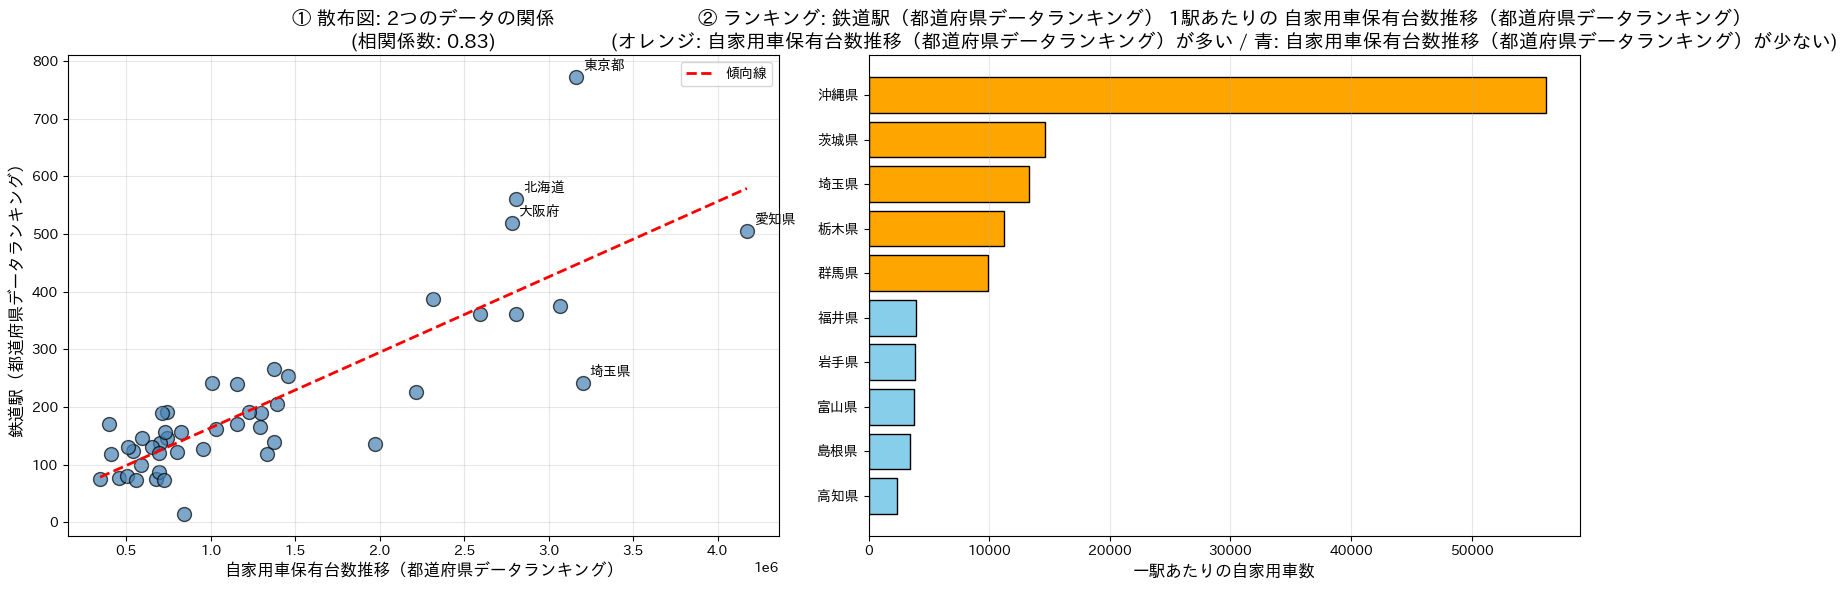

分析完了: simple_analysis.png を保存しました。
決定係数 (R^2): 0.6893


In [ ]:
if len(df) > 0:
    # 統計量
    slope, intercept, r_value, _, _ = stats.linregress(df['Number_of_privately_owned_vehicles'], df['Number_of_railway_stations'])
    
    # 図の作成 (横に2つ並べる)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- グラフ1: 散布図 (相関を見る) ---
    ax1.scatter(df['Number_of_privately_owned_vehicles'], df['Number_of_railway_stations'], s=100, alpha=0.7, color='steelblue', edgecolors='black')
    
    # 回帰直線
    x_range = np.linspace(df['Number_of_privately_owned_vehicles'].min(), df['Number_of_privately_owned_vehicles'].max(), 100)
    ax1.plot(x_range, slope * x_range + intercept, 'r--', linewidth=2, label='傾向線')
    
    # 特徴的な県（両端）に名前を表示
    targets = pd.concat([df.nlargest(3, 'Number_of_privately_owned_vehicles'), df.nlargest(3, 'Number_of_railway_stations')])
    for idx, row in targets.drop_duplicates().iterrows():
        ax1.annotate(row['prefecture'], (row['Number_of_privately_owned_vehicles'], row['Number_of_railway_stations']), xytext=(5, 5), textcoords='offset points')
    ax1.set_title(f'① 散布図: 2つのデータの関係\n(相関係数: {r_value:.2f})', fontsize=14)
    ax1.set_xlabel(title1, fontsize=12)
    ax1.set_ylabel(title2, fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # --- グラフ2: 比率ランキング (特徴を見る) ---
    # 新しい指標: 「値1 ÷ 値2」 (例: 1駅あたりの自家用車数)
    df['ratio'] = df['Number_of_privately_owned_vehicles'] / df['Number_of_railway_stations']
    
    # 上位5と下位5を抽出
    top5 = df.nlargest(5, 'ratio')
    bottom5 = df.nsmallest(5, 'ratio').sort_values('ratio', ascending=False) 
    ranking_df = pd.concat([top5, bottom5])
    
    # 棒グラフ描画
    colors = ['orange']*5 + ['skyblue']*5
    ax2.barh(ranking_df['prefecture'], ranking_df['ratio'], color=colors, edgecolor='black')
    ax2.invert_yaxis() # 上位を上に表示
    
    ax2.set_title(f'② ランキング: {title2} 1駅あたりの {title1}\n(オレンジ: {title1}が多い / 青: {title1}が少ない)', fontsize=14)
    ax2.set_xlabel('一駅あたりの自家用車数', fontsize=12)
    ax2.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('simple_analysis.png')
    plt.show()
    
    print("分析完了: simple_analysis.png を保存しました。")
    print(f"決定係数 (R^2): {r_value**2:.4f}")

else:
    print("データが取得できませんでした。")